In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv('hmeq.csv')

In [3]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Для начала давайте рассмотрим длю пропусков в каждой колонке:

In [44]:
df.isna().mean(axis=0)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

При рассмотрении этих данных стоит учитывать тот факт, что все эти заявки - кредиты, уже одобренные прошлым алгоритмом. Из-за этого отличия в данных говорят скорее не об особенностях клиентов, а о предвзятостях существующей модели.

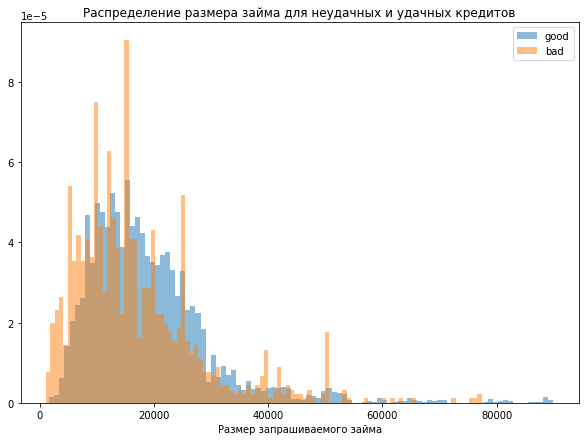

In [36]:
plt.figure(figsize=(10, 7))
plt.hist(df['LOAN'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['LOAN'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Размер запрашиваемого займа')
plt.title('Распределение размера займа для неудачных и удачных кредитов')
plt.show()

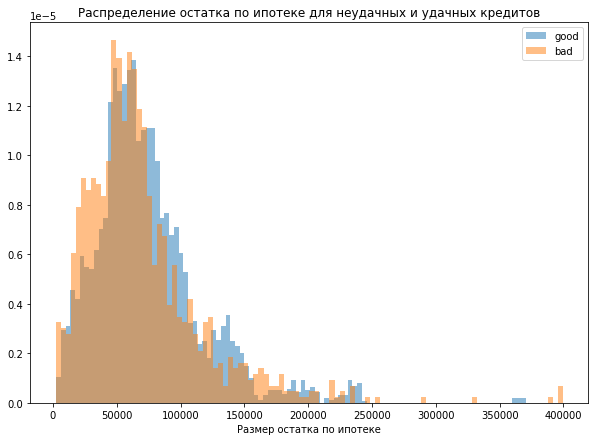

In [38]:
plt.figure(figsize=(10, 7))

plt.hist(df['MORTDUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['MORTDUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Размер остатка по ипотеке')
plt.title('Распределение остатка по ипотеке для неудачных и удачных кредитов')

plt.show()

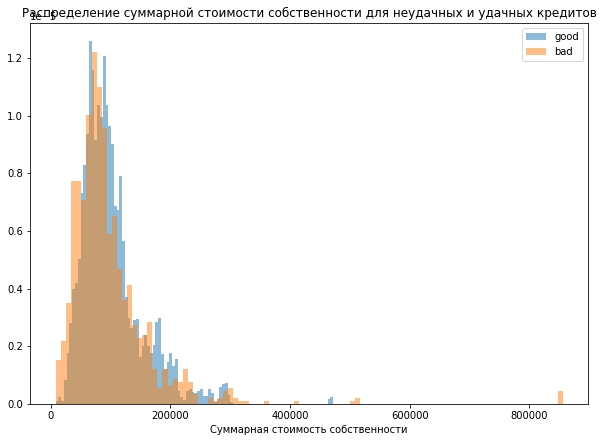

In [39]:
plt.figure(figsize=(10, 7))

plt.hist(df['VALUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['VALUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Суммарная стоимость собственности')
plt.title('Распределение суммарной стоимости собственности для неудачных и удачных кредитов')

plt.show()

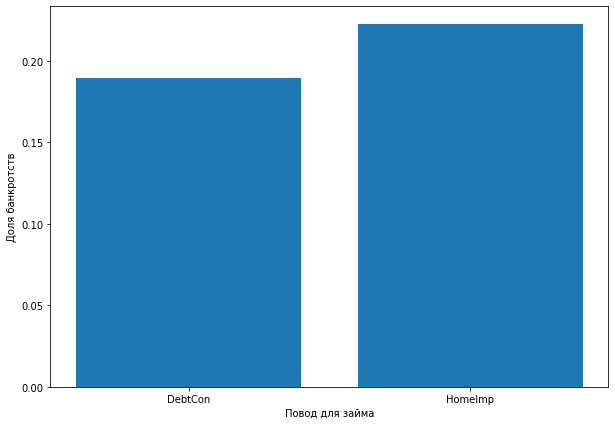

In [32]:
plt.figure(figsize=(10, 7))
plt.bar(x=['DebtCon', 'HomeImp'], height=(df.groupby('REASON').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Повод для займа')
plt.show()

Интуитивно понятно, что реструктуризация долгов - потенциально более рискованная инвестиция, чем покупка для улучшения дома. Возможно прошлые данные овер-компенсировали этот риск, поэтому в нашем датасете реструктуризация статистически надежнее.

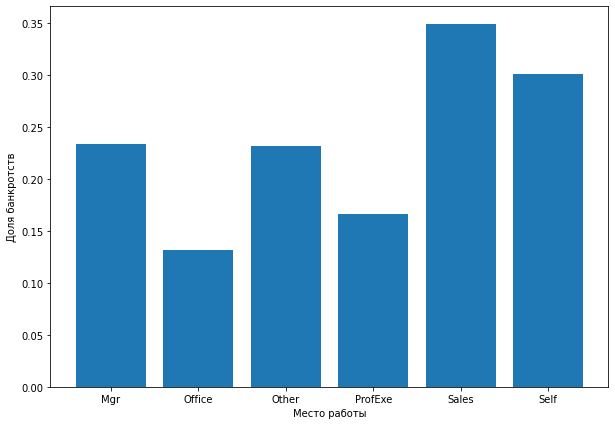

In [41]:
plt.figure(figsize=(10, 7))
plt.bar(x=(df.groupby('JOB').mean()['BAD']).index, height=(df.groupby('JOB').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Место работы')

plt.show()

Давайте оценим важность признаков с помощью t-статистики, чтобы выделить наиболее значимые для нашей классификации

In [42]:
dfpos = df[df['BAD'] == 0].drop(['BAD', 'JOB', 'REASON'] , axis=1)
dfneg = df[df['BAD'] == 1].drop(['BAD', 'JOB', 'REASON'] , axis=1)
t = np.abs(dfpos.mean(axis=0) - dfneg.mean(axis=0)) / np.sqrt((len(dfpos) * dfpos.std(axis=0)**2 + len(dfneg) * dfneg.std(axis=0)**2)/ (len(dfpos) + len(dfneg)))


In [43]:
t

LOAN       0.188425
MORTDUE    0.120885
VALUE      0.076650
YOJ        0.148999
DEROG      0.715846
DELINQ     0.944193
CLAGE      0.435324
NINQ       0.441615
CLNO       0.010427
DEBTINC    0.609487
dtype: float64

'DEROG', 'DELINQ' - обобщая, эти признаки говорят нам об уже просроченных кредитах. Понятно, почему эти признаки очень важны.

'DEBTINC' - отношение долга к доходу

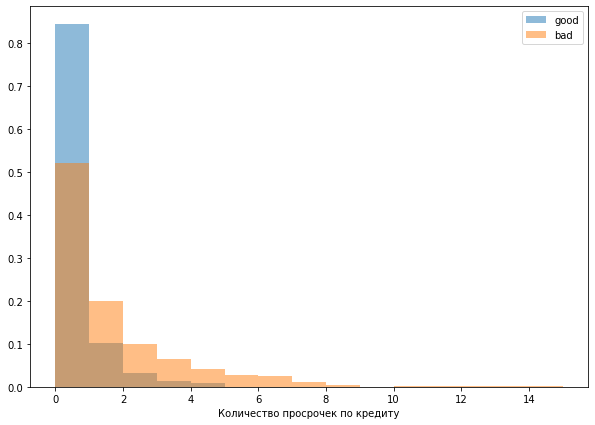

In [55]:
plt.figure(figsize=(10, 7))

plt.hist(df['DELINQ'][df['BAD'] == 0], bins=5, alpha=0.5, label='good', density=True)
plt.hist(df['DELINQ'][df['BAD'] == 1], bins=15, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Количество просрочек по кредиту')

plt.show()

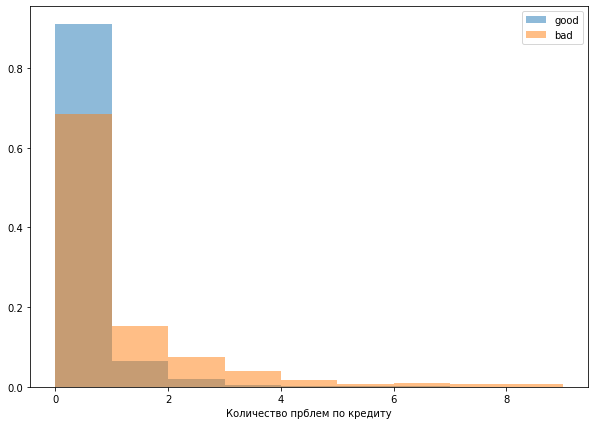

In [54]:
plt.figure(figsize=(10, 7))

plt.hist(df['DEROG'][df['BAD'] == 0], bins=range(10), alpha=0.5, label='good', density=True)
plt.hist(df['DEROG'][df['BAD'] == 1], bins=range(10), alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Количество прблем по кредиту')

plt.show()

In [56]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [57]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [58]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Давайте для начала заполним пропуски в категориальных переменных отдельным значением, в числовых - средним, а переменную с наибольшим количеством пропусков пока удалим.

In [60]:
import copy

In [75]:
df_pure = copy.deepcopy(df).drop('DEBTINC', axis=1)

In [76]:
df_pure[['JOB', 'REASON']] = df_pure[['JOB', 'REASON']].fillna('NAN')

In [78]:
df_pure = df_pure.fillna(df_pure.mean(axis=0))

In [79]:
y = df_pure['BAD'].values
X = df_pure.drop("BAD", axis=1).values

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
from sklearn.preprocessing import OneHotEncoder

Закодируем категориальные переменные

In [83]:
X = np.concatenate((X[:, :3], OneHotEncoder(sparse=False).fit_transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=179)


In [85]:
isnatrain, isnatest = train_test_split(df.isna().mean(axis=1), test_size=0.3, random_state=179)

In [86]:
mod = RandomForestClassifier(n_estimators=5000).fit(X_train, y_train)

In [87]:
print(mod.score(X_test, y_test))

0.9345637583892618


In [97]:
y_pred = mod.predict(X_test)

In [106]:
print(f"Positive train targets: {(y_train == 1).sum()}, negative train targets: {(y_train == 0).sum()}, ratio: {(y_train == 1).sum() / (y_train == 0).sum()}")
print(f"Positive test targets: {(y_test == 1).sum()}, negative test targets: {(y_test == 0).sum()}, ratio: {(y_test == 1).sum() / (y_test == 0).sum()}")
print(f"Positive predictions: {(y_pred == 1).sum()}, negative predictions: {(y_pred == 0).sum()}, ratio: {(y_pred == 1).sum() / (y_pred == 0).sum()}")

Positive train targets: 825, negative train targets: 3347, ratio: 0.2464893934867045
Positive test targets: 364, negative test targets: 1424, ratio: 0.2556179775280899
Positive predictions: 255, negative predictions: 1533, ratio: 0.16634050880626222


Accuracy - не самая удачная метрика, хотя баланс классов всего 4:1

In [94]:
from sklearn.metrics import accuracy_score
def kappa(y0, y1, pos=1, neg=0):
    po = accuracy_score(y0, y1)

    pos0 = (y0 == pos).mean()
    pos1 = (y1 == pos).mean()
    pe = (pos0 * pos1) + (1 - pos0) * (1 - pos1)

    k = (po - pe) / (1 - pe)
    return k

In [90]:
def matthews(pred, target, pos=1, neg=0):
    tp = np.sum((pred == pos) & (target == pos))
    tn = np.sum((pred == neg) & (target == neg))
    fp = np.sum((pred == pos) & (target == neg))
    fn = np.sum((pred == neg) & (target == pos))

    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        return 0 # условность, чтобы не вылезало так много nan

    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [123]:
print(f"Kappa value: {kappa(y_pred, y_test)}")
print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
print(f"ROC-AUC value: {roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))}")


Kappa value: 0.7728924844647672
Matthews correlation coefficient: 0.7907953453805613
ROC-AUC value: 0.9853830333991851
PR-AUC value: 0.9609472028991017


In [130]:
print(f"Precision value: {precision_score(y_test, y_pred)}")
print(f"Recall value: {recall_score(y_test, y_pred)}")

Precision value: 0.984313725490196
Recall value: 0.6895604395604396


Было бы логично предположить, что невозврат денег для нас несет больше урона, чем бы нам принесло успешное возвращение. Это говорит нам о том, что порог выдачи кредита стоит выставить ниже чем 0.5 вероятности дефолта

Напишем функцию, которая максимизирует ожидание прибыли, исходя из предположения о том, что наша выгода составляет x% суммы, и если человек не возвращает сумму, он не возвращает ее целиком

In [136]:
def get_prediction(mod, X_test, y_test, x=15):
    y_prob = mod.predict_proba(X_test)[:, 1]
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

In [140]:
y_pred_finance = get_prediction(mod, X_test, y_test)

Введем метрику, которая оценивает лосс как упущенную выгоду, по сравнению с идеальным предсказанием.

In [144]:
def get_loss(y_pred, y_target, loan, x=15):
    return (((y_pred == 1) & (y_target == 0)) * loan * x / 100 +  ((y_pred == 0) & (y_target == 1)) * loan).sum()

In [146]:
get_loss(y_pred_finance, y_test, X_test[:, 0])

609590.0

In [147]:
get_loss(y_test, y_test, X_test[:, 0])

0.0

Если выдавать кредит по предсказанию модели:

In [148]:
get_loss(y_pred, y_test, X_test[:, 0])

2113645.0

Давайте проведем те же манипуляции, но с использованием SMOTE для апсемплинга минорного класса.

In [149]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [150]:
def print_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    print(f"Kappa value: {kappa(y_pred, y_test)}")
    print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
    print(f"ROC-AUC value: {roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
    print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))}")
    print(f"Precision value: {precision_score(y_test, y_pred)}")
    print(f"Recall value: {recall_score(y_test, y_pred)}")
    y_pred_finance = get_prediction(mod, X_test, y_test)
    print(f"Loss: {get_loss(y_pred_finance, y_test, X_test[:, 0])}")

In [151]:
X_train_new, y_train_new = SMOTE(sampling_strategy=1/2).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [152]:
mod2 = RandomForestClassifier(n_estimators=5000).fit(X_train_new, y_train_new)

In [153]:
print(mod2.score(X_test, y_test))

0.9412751677852349


Новые значения:

In [154]:
print_metrics(mod2, X_test, y_test)

Kappa value: 0.8007708535845116
Matthews Correlation Coefficient: 0.8124388888915726
ROC-AUC value: 0.9861720968638104
PR-AUC value: 0.9604497120020927
Precision value: 0.9709090909090909
Recall value: 0.7335164835164835
Loss: 701650.0


Старые значения:

In [155]:
print_metrics(mod, X_test, y_test)

Kappa value: 0.7728924844647672
Matthews Correlation Coefficient: 0.7907953453805613
ROC-AUC value: 0.9853830333991851
PR-AUC value: 0.9609472028991017
Precision value: 0.984313725490196
Recall value: 0.6895604395604396
Loss: 609590.0


Забавно, все метрики улучшены, а денег мы теряем больше.